# Surface Defect Detection with Deep Learning 

In [1]:
## Author: Adarsh Gouda; adhi.pesit@gmail.com

In [2]:
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from scipy.ndimage.measurements import label
import time

import warnings
warnings.filterwarnings('ignore')

Invalid MIT-MAGIC-COOKIE-1 key/tmp/ipykernel_114968/3230617028.py:10: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


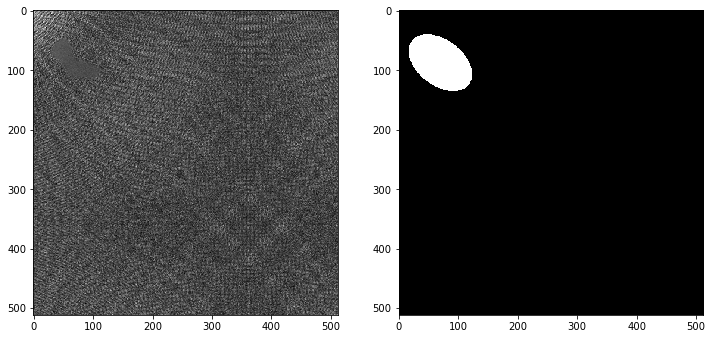

In [3]:
data_dir = "./Class1_def"

from utils import plot_ellipse_seg_test

plot_ellipse_seg_test(os.path.join(data_dir, "1.png"))

In [4]:
from utils import load_images_masks

In [5]:
X, y = load_images_masks(data_dir, img_type='png', img_format='gray', 
                         resize=(512, 512), ellipse=True)

In [6]:
X.shape

(150, 512, 512, 1)

In [7]:
y.shape

(150, 512, 512, 1)

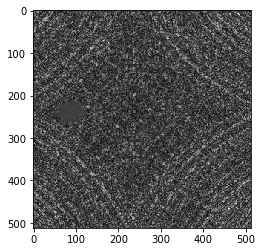

In [8]:
plt.imshow(X[0,:,:,0], cmap='gray')

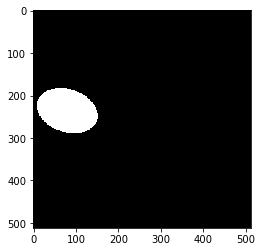

In [9]:
plt.imshow(y[0,:,:,0], cmap='gray')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
X_train.shape

(105, 512, 512, 1)

In [12]:
X_test.shape

(45, 512, 512, 1)

In [13]:
img_rows = 512
img_cols = 512

In [14]:
def get_small_unet():
    inputs = Input((img_rows, img_cols, 1))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(16, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(8, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [15]:
model = get_small_unet()

2022-06-25 21:32:27.918993: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-06-25 21:32:27.919028: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aghora
2022-06-25 21:32:27.919033: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aghora
2022-06-25 21:32:27.919196: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.5
2022-06-25 21:32:27.919211: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.73.5
2022-06-25 21:32:27.919214: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.73.5
2022-06-25 21:32:27.919418: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operat

In [16]:
def smooth_dice_coeff(smooth=1.):

    smooth = float(smooth)

    # IOU or dice coeff calculation
    def IOU_calc(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)

            return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def IOU_calc_loss(y_true, y_pred):
        return -IOU_calc(y_true, y_pred)
    return IOU_calc, IOU_calc_loss

IOU_calc, IOU_calc_loss = smooth_dice_coeff(0.00001)

In [17]:
model.compile(optimizer=Adam(lr=1e-4), loss=IOU_calc_loss, metrics=[IOU_calc])

In [18]:
history = model.fit(X_train, y_train, batch_size=10, epochs=60, 
                    verbose=1, validation_split=0.1)

Epoch 1/60
10/10 [==============================] - 41s 4s/step - loss: -0.0730 - IOU_calc: 0.0715 - val_loss: -0.0665 - val_IOU_calc: 0.0656
Epoch 2/60
10/10 [==============================] - 41s 4s/step - loss: -0.0797 - IOU_calc: 0.0802 - val_loss: -0.0749 - val_IOU_calc: 0.0749
Epoch 3/60
10/10 [==============================] - 41s 4s/step - loss: -0.0939 - IOU_calc: 0.0943 - val_loss: -0.0994 - val_IOU_calc: 0.1036
Epoch 4/60
10/10 [==============================] - 41s 4s/step - loss: -0.1351 - IOU_calc: 0.1371 - val_loss: -0.1809 - val_IOU_calc: 0.2001
Epoch 5/60
10/10 [==============================] - 40s 4s/step - loss: -0.2263 - IOU_calc: 0.2196 - val_loss: -0.2285 - val_IOU_calc: 0.2947
Epoch 6/60
10/10 [==============================] - 39s 4s/step - loss: -0.2971 - IOU_calc: 0.2947 - val_loss: -0.3183 - val_IOU_calc: 0.3194
Epoch 7/60
10/10 [==============================] - 39s 4s/step - loss: -0.3065 - IOU_calc: 0.2958 - val_loss: -0.3273 - val_IOU_calc: 0.3768
Epoch 

10/10 [==============================] - 39s 4s/step - loss: -0.8584 - IOU_calc: 0.8592 - val_loss: -0.8513 - val_IOU_calc: 0.8970
Epoch 59/60
10/10 [==============================] - 39s 4s/step - loss: -0.8616 - IOU_calc: 0.8594 - val_loss: -0.8125 - val_IOU_calc: 0.8531
Epoch 60/60
10/10 [==============================] - 39s 4s/step - loss: -0.8590 - IOU_calc: 0.8571 - val_loss: -0.8547 - val_IOU_calc: 0.8988


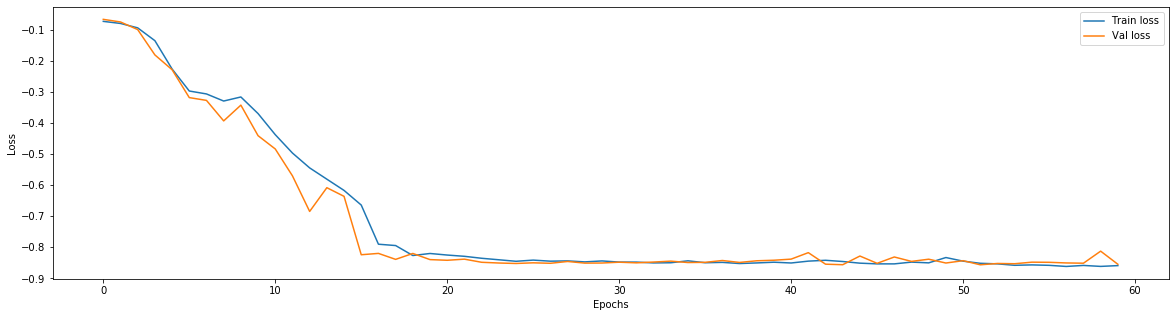

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Train loss')
plt.plot(model.history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

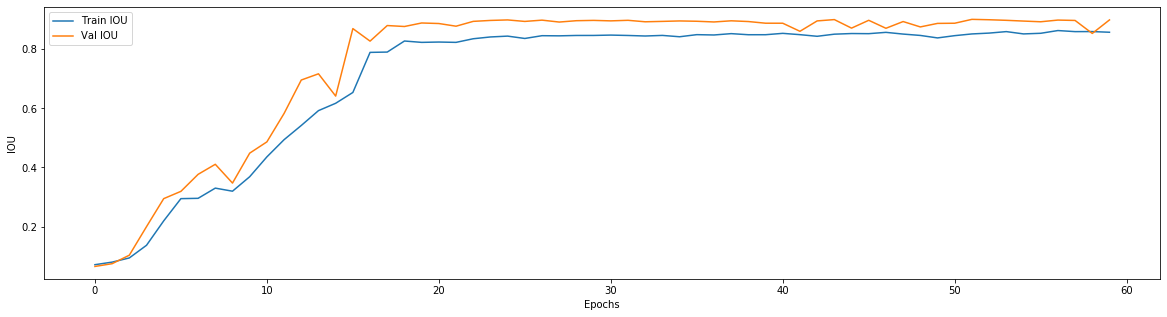

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['IOU_calc'], label='Train IOU')
plt.plot(model.history.history['val_IOU_calc'], label='Val IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()

## Prediction on Test Data

In [21]:
predict = model.predict(X_test)

2022-06-25 22:13:14.214489: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 805306368 exceeds 10% of free system memory.


In [22]:
import numpy as np
import cv2


def predict_evaluation(pred, image, label):
    '''
    '''
    # transform gray image to rgb
    img = np.array(image, np.uint8)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # scale pred and mask's pixel range to 0~255
    im_label = np.array(255*label, dtype=np.uint8)
    im_pred = np.array(255*pred, dtype=np.uint8)

    # transform both of them to rgb
    rgb_label = cv2.cvtColor(im_label, cv2.COLOR_GRAY2RGB)
    rgb_pred = cv2.cvtColor(im_pred, cv2.COLOR_GRAY2RGB)

    rgb_label[:, :, 1:3] = 0*rgb_label[:, :, 1:2]
    rgb_pred[:, :, 0] = 0*rgb_pred[:, :, 0]
    rgb_pred[:, :, 2] = 0*rgb_pred[:, :, 2]

    img_pred = cv2.addWeighted(rgb_img, 1, rgb_pred, 0.3, 0)
    img_label = cv2.addWeighted(rgb_img, 1, rgb_label, 0.3, 0)

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_img)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img_pred)
    plt.title('Prediction')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img_label)
    plt.title('Ground truth')
    plt.axis('off')

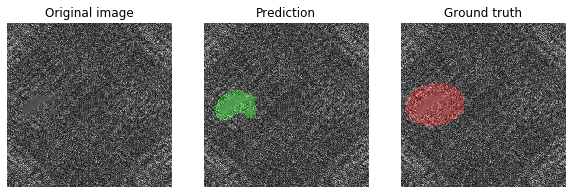

In [23]:
predict_evaluation(predict[0,:,:,0], X_test[0,:,:,0], y_test[0,:,:,0])

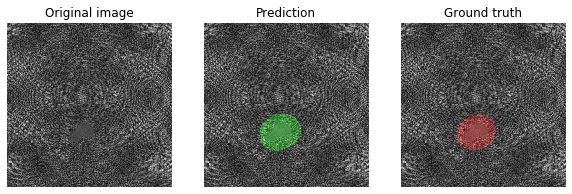

In [24]:
predict_evaluation(predict[1,:,:,0], X_test[1,:,:,0], y_test[1,:,:,0])

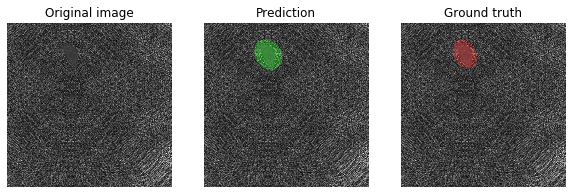

In [25]:
predict_evaluation(predict[2,:,:,0], X_test[2,:,:,0], y_test[2,:,:,0])

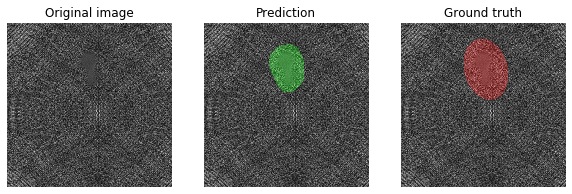

In [26]:
predict_evaluation(predict[3,:,:,0], X_test[3,:,:,0], y_test[3,:,:,0])

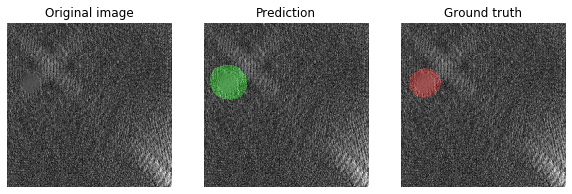

In [27]:
predict_evaluation(predict[4,:,:,0], X_test[4,:,:,0], y_test[4,:,:,0])

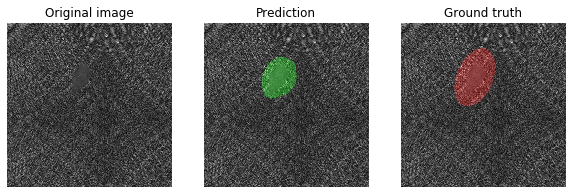

In [28]:
predict_evaluation(predict[5,:,:,0], X_test[5,:,:,0], y_test[5,:,:,0])

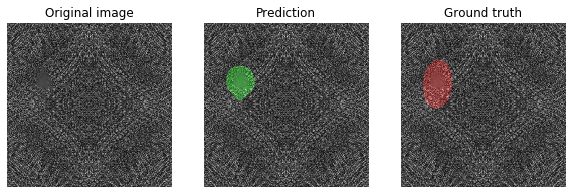

In [29]:
predict_evaluation(predict[6,:,:,0], X_test[6,:,:,0], y_test[6,:,:,0])

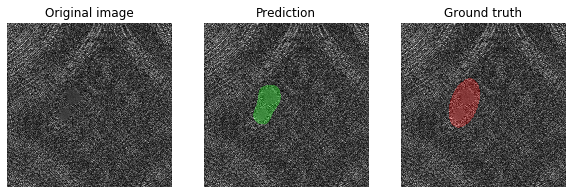

In [30]:
predict_evaluation(predict[7,:,:,0], X_test[7,:,:,0], y_test[7,:,:,0])

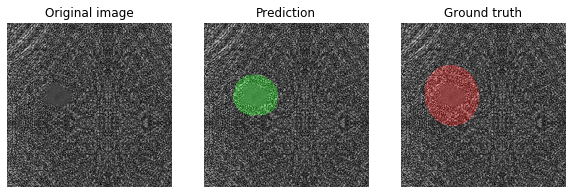

In [31]:
predict_evaluation(predict[8,:,:,0], X_test[8,:,:,0], y_test[8,:,:,0])

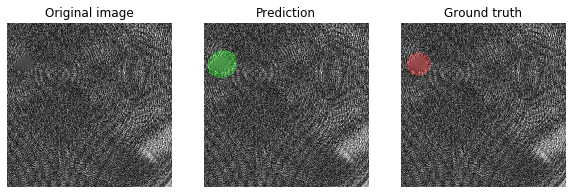

In [32]:
predict_evaluation(predict[9,:,:,0], X_test[9,:,:,0], y_test[9,:,:,0])